# Logistic Model Implementation

## Step1: Library Load & Time Cost Record

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import time, os, psutil, atexit                  
process      = psutil.Process(os.getpid())       
_t0          = time.perf_counter()               
_mem0        = process.memory_info().rss         

def _report():
    dt   = time.perf_counter() - _t0            
    mem1 = process.memory_info().rss            
    print(f"\n[STATS] runtime = {dt:,.2f} s")
    print(f"[STATS] memory  = {_mem0/2**20:,.2f} → {mem1/2**20:,.2f} MB "
          f"(Δ {(mem1-_mem0)/2**20:,.2f} MB)")

## Step1: Load npz File Data

In [3]:
data = np.load('image_data.npz')
images_loaded = data['images']
labels_loaded = data['labels']

df = pd.DataFrame({
    'normalized_image_data': list(images_loaded),
    'label': list(labels_loaded)
})

print(f'df.shape: {df.shape}')
    
df_cleaned = df.dropna(subset=['normalized_image_data', 'label'])

print(f'df_cleaned.shape: {df_cleaned.shape}')

df.shape: (1012, 2)
df_cleaned.shape: (1012, 2)


## Step2: Extract HOG Features

<mark>This block may take lots of time to run (5min)<mark>

In [4]:
from tqdm import tqdm
import numpy as np

def compute_gradient(image):
    # Use Sobel operator to compute gradients
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    # Ensure image is 2D
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)  # Convert to grayscale

    image = np.nan_to_num(image)
    
    # Compute x and y gradients
    gx = np.zeros_like(image, dtype=np.float32)
    gy = np.zeros_like(image, dtype=np.float32)
    
    # Apply Sobel filters
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            gx[i, j] = np.sum(image[i-1:i+2, j-1:j+2] * sobel_x)
            gy[i, j] = np.sum(image[i-1:i+2, j-1:j+2] * sobel_y)
    
    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx) * (180 / np.pi)  # Convert to degrees [0, 180]
    angle = np.where(angle < 0, angle + 180, angle)
    
    return magnitude, angle

def extract_hog_features(image, cell_size=(16, 16), block_size=(2, 2), bins=9):
    # Compute gradient magnitude and orientation
    magnitude, angle = compute_gradient(image)
    
    # Parameter settings
    rows, cols = magnitude.shape
    cell_rows, cell_cols = cell_size
    block_rows, block_cols = block_size
    
    # Calculate number of cells
    n_cells_row = rows // cell_rows
    n_cells_col = cols // cell_cols
    
    # Initialize HOG feature vector
    hog_features = []
    
    # Iterate through each cell
    for i in range(n_cells_row):
        for j in range(n_cells_col):
            # Get current cell's gradient magnitude and orientation
            cell_magnitude = magnitude[i*cell_rows:(i+1)*cell_rows, j*cell_cols:(j+1)*cell_cols]
            cell_angle = angle[i*cell_rows:(i+1)*cell_rows, j*cell_cols:(j+1)*cell_cols]
            
            # Compute histogram
            hist = np.zeros(bins)
            for mag, ang in zip(cell_magnitude.flatten(), cell_angle.flatten()):
                bin_idx = int(ang * bins / 180.0) % bins
                hist[bin_idx] += mag
            
            # Normalize
            hist = hist / (np.sum(hist) + 1e-6)
            hog_features.extend(hist)

    hog_features = np.array(hog_features, dtype=np.float32)
    
    return hog_features

# 使用 tqdm 打印进度
X = []
y = df_cleaned['label'].values.astype(np.float32)

for img in tqdm(df_cleaned['normalized_image_data'], desc="Extracting HOG features"):
    X.append(extract_hog_features(img))

X = np.array(X, dtype=np.float32)

Extracting HOG features: 100%|██████████| 1012/1012 [05:24<00:00,  3.12it/s]


## Step3: Split & Normalize Data

In [5]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma = np.where(sigma < 1e-10, 1.0, sigma)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_norm, mu, sigma = featureNormalize(X)
X = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


## Step4: Define momentum-based GD

### Momentum-Based Gradient Descent
<img src="md_image_material/momentum_gd.png" width="500" height="350" style="float: left; margin-right: 10px;">
<img src="md_image_material/momentum_gd1.png" width="500" height="350" style="float: left; margin-right: 10px;">

In [6]:

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def computeCost(X, y, theta, lambda_=1.2): 
    m = len(y)
    h = sigmoid(X @ theta.T)
    h = np.clip(h, 1e-15, 1-1e-15)
    
    # L2
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)  
    cost = (-y * np.log(h) - (1-y) * np.log(1-h)).mean() + reg_term
    return float(cost)

def gradientDescent(X, y, theta, alpha, num_iters, lambda_=1.0, print_cost=False, X_val=None, y_val=None, patience=10):
    """
    patience: early stop if no LOSS optim in setting patience epoch ranges...
    momentum computation: remember the gradient direction of the previous iterations and add it to the current gradient at a certain ratio (here 0.9) in the current iteration
    """
    
    m = len(y)
    cost_history = []
    
    # new form to speed up the training speed
    momentum = 0.9 #​​Momentum Acceleration​​: Uses a momentum term (momentum=0.9) to speed up convergence and reduce oscillations
    velocity = np.zeros_like(theta)
    
    # Initialize validation tracking 
    if X_val is not None and y_val is not None:
        val_cost_history = []
        best_val_cost = float('inf')
        best_theta = theta.copy()
        no_improvement = 0
        min_delta = 0.001  
        
    for i in range(num_iters):
        z = X @ theta.T
        h = sigmoid(z)
        error = h - y.reshape(-1, 1)
        gradients = (X.T @ error / m).T
        gradients[:, 1:] += (lambda_ / m) * theta[:, 1:]
        
        velocity = momentum * velocity - alpha * gradients
        theta += velocity

        train_cost = computeCost(X, y, theta, lambda_)
        cost_history.append(train_cost)

        if X_val is not None and y_val is not None:
            val_cost = computeCost(X_val, y_val, theta, lambda_)
            val_cost_history.append(val_cost)
            
            # Early stopping logic 
            if val_cost < best_val_cost - min_delta: 
                best_val_cost = val_cost
                best_theta = theta.copy()
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    if print_cost:
                        print(f"Early stopping at iteration {i}")
                    theta = best_theta  # Revert to best weights
                    break

        if print_cost and i % 500 == 0:
            msg = f"Iteration {i}: Train Cost = {train_cost:.6f}"
            if X_val is not None:
                msg += f" | Val Cost = {val_cost:.6f}"
            print(msg)
    
    # Return best weights if early stopping was used
    if X_val is not None and y_val is not None:
        return theta, cost_history, val_cost_history
    else:
        return theta, cost_history

## Step5: Training With Gradient Descent (Ouptut: theta)

In [7]:

np.random.seed(42)
initial_theta = np.random.uniform(-0.1, 0.1, (1, X.shape[1]))

alpha = 0.001  
lambda_ = 1.5   
iters = 1500

print("\nTraining Logistic Regression with manual HOG features...")
theta, cost_history = gradientDescent(X_train, y_train, initial_theta, alpha, iters, lambda_, print_cost=True)



Training Logistic Regression with manual HOG features...
Iteration 0: Train Cost = 1.154547
Iteration 500: Train Cost = 2.210164
Iteration 1000: Train Cost = 2.568578


## Step6: Define Predict Functions

In [8]:
def predict(X, theta, threshold=0.5):
    try:

        X_normalized = (X[:, 1:] - mu) / sigma 
        X_normalized = np.hstack((np.ones((X_normalized.shape[0], 1)), X_normalized))
        
        probabilities = sigmoid(X_normalized @ theta.T)
        return (probabilities >= threshold).astype(int)
    except Exception as e:
        print(f"Prediction error: {e}")
        return np.zeros(len(X))


## Step7: Evaluate Performance & Threshold Analysis (optimal threshold)

A threshold analysis is performed on the prediction results of the binary classification model **to find an optimal classification threshold** to **maximize the F1-score** of the model on the test set.

In [9]:
def evaluate_performance(y_true, y_pred):
    print("\nDetailed Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")

    unique, counts = np.unique(y_pred, return_counts=True)
    print(f"Prediction distribution: {dict(zip(unique, counts/len(y_pred)))}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

print("\nTraining Set Performance:")
y_train_pred = predict(X_train, theta, threshold=0.5)
evaluate_performance(y_train, y_train_pred)

print("\nTest Set Performance:")
y_test_pred = predict(X_test, theta, threshold=0.5)
evaluate_performance(y_test, y_test_pred)

#  Analyse thresholds（Suggested optimal threshold: 0.10）
print("\nThreshold Analysis:")
thresholds = np.linspace(0.1, 0.9, 9)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_test_adjusted = predict(X_test, theta, threshold=threshold)
    current_f1 = f1_score(y_test, y_test_adjusted)
    print(f"Threshold {threshold:.1f}: F1 = {current_f1:.4f}, "
        f"Precision = {precision_score(y_test, y_test_adjusted, zero_division=0):.4f}, "
        f"Recall = {recall_score(y_test, y_test_adjusted, zero_division=0):.4f}")
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nSuggested optimal threshold: {best_threshold:.2f}")



Training Set Performance:

Detailed Evaluation:
Accuracy: 0.9873
Precision: 0.9953
Recall: 0.9839
F1 Score: 0.9896
Prediction distribution: {0: 0.3940677966101695, 1: 0.6059322033898306}

Confusion Matrix:
[[272   2]
 [  7 427]]

Test Set Performance:

Detailed Evaluation:
Accuracy: 0.8849
Precision: 0.9521
Recall: 0.8548
F1 Score: 0.9008
Prediction distribution: {0: 0.4506578947368421, 1: 0.5493421052631579}

Confusion Matrix:
[[110   8]
 [ 27 159]]

Threshold Analysis:
Threshold 0.1: F1 = 0.9070, Precision = 0.9527, Recall = 0.8656
Threshold 0.2: F1 = 0.9008, Precision = 0.9521, Recall = 0.8548
Threshold 0.3: F1 = 0.9008, Precision = 0.9521, Recall = 0.8548
Threshold 0.4: F1 = 0.9008, Precision = 0.9521, Recall = 0.8548
Threshold 0.5: F1 = 0.9008, Precision = 0.9521, Recall = 0.8548
Threshold 0.6: F1 = 0.9008, Precision = 0.9521, Recall = 0.8548
Threshold 0.7: F1 = 0.9034, Precision = 0.9578, Recall = 0.8548
Threshold 0.8: F1 = 0.9060, Precision = 0.9636, Recall = 0.8548
Threshold 0

## Step8: Best Threshold & Comparision

In [10]:
# Retrain the model with the best threshold found
best_threshold = 0.10  

print(f"\nRetraining and evaluating with optimal threshold {best_threshold:.2f}...")

np.random.seed(42)
initial_theta = np.random.uniform(-0.1, 0.1, (1, X.shape[1]))

alpha = 0.005
iters = 1000
lambda_ = 1.2

print("\nTraining Logistic Regression with manual HOG features (using best threshold)...")
theta, cost_history = gradientDescent(X_train, y_train, initial_theta, alpha, iters, lambda_, print_cost=True)

# Now evaluate performance using the best threshold
print("\nTraining Set Performance with Best Threshold:")
y_train_pred_best = predict(X_train, theta, threshold=best_threshold)
evaluate_performance(y_train, y_train_pred_best)

print("\nTest Set Performance with Best Threshold:")
y_test_pred_best = predict(X_test, theta, threshold=best_threshold)
evaluate_performance(y_test, y_test_pred_best)

# Compare with default threshold (0.5) for reference
print("\nComparison with Default Threshold (0.5):")
print("\nTraining Set Performance with Threshold=0.5:")
y_train_pred_default = predict(X_train, theta, threshold=0.5)
evaluate_performance(y_train, y_train_pred_default)

print("\nTest Set Performance with Threshold=0.5:")
y_test_pred_default = predict(X_test, theta, threshold=0.5)
evaluate_performance(y_test, y_test_pred_default)

# Print improvement summary
def print_improvement(metric, best, default):
    improvement = (best - default) / default * 100
    direction = "increased" if improvement >= 0 else "decreased"
    print(f"{metric}: {default:.4f} → {best:.4f} ({direction} by {abs(improvement):.1f}%)")

print("\nPerformance Improvement Summary:")
print("Training Set:")
print_improvement("F1 Score", 
                f1_score(y_train, y_train_pred_best, zero_division=0),
                f1_score(y_train, y_train_pred_default, zero_division=0))

print("\nTest Set:")
print_improvement("F1 Score", 
                f1_score(y_test, y_test_pred_best, zero_division=0),
                f1_score(y_test, y_test_pred_default, zero_division=0))




Retraining and evaluating with optimal threshold 0.10...

Training Logistic Regression with manual HOG features (using best threshold)...
Iteration 0: Train Cost = 1.158915
Iteration 500: Train Cost = 3.130087

Training Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9958
Precision: 0.9977
Recall: 0.9954
F1 Score: 0.9965
Prediction distribution: {0: 0.3884180790960452, 1: 0.6115819209039548}

Confusion Matrix:
[[273   1]
 [  2 432]]

Test Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9276
Precision: 0.9607
Recall: 0.9194
F1 Score: 0.9396
Prediction distribution: {0: 0.4144736842105263, 1: 0.5855263157894737}

Confusion Matrix:
[[111   7]
 [ 15 171]]

Comparison with Default Threshold (0.5):

Training Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9944
Precision: 0.9977
Recall: 0.9931
F1 Score: 0.9954
Prediction distribution: {0: 0.3898305084745763, 1: 0.6101694915254238}

Confusion Matrix:
[[273   1]
 [  3 431]]

T

```
Retraining and evaluating with optimal threshold 0.10...

Training Logistic Regression with manual HOG features (using best threshold)...
Iteration 0: Train Cost = 1.158915
Iteration 500: Train Cost = 3.130087

Training Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9958
Precision: 0.9977
Recall: 0.9954
F1 Score: 0.9965
Prediction distribution: {0: 0.3884180790960452, 1: 0.6115819209039548}

Confusion Matrix:
[[273   1]
 [  2 432]]

Test Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9276
Precision: 0.9607
Recall: 0.9194
F1 Score: 0.9396
Prediction distribution: {0: 0.4144736842105263, 1: 0.5855263157894737}

Confusion Matrix:
[[111   7]
 [ 15 171]]


---------------------------------------------------------------------------


Comparison with Default Threshold (0.5):

Training Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9944
Precision: 0.9977
Recall: 0.9931
F1 Score: 0.9954
Prediction distribution: {0: 0.3898305084745763, 1: 0.6101694915254238}

Confusion Matrix:
[[273   1]
 [  3 431]]

Test Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9178
Precision: 0.9600
Recall: 0.9032
F1 Score: 0.9307
Prediction distribution: {0: 0.4243421052631579, 1: 0.5756578947368421}

Confusion Matrix:
[[111   7]
 [ 18 168]]


---------------------------------------------------------------------------


Performance Improvement Summary:
Training Set:
F1 Score: 0.9954 → 0.9965 (increased by 0.1%)

Test Set:
F1 Score: 0.9307 → 0.9396 (increased by 0.9%)

```

## Step9: Cross Validation

In [11]:
from sklearn.model_selection import KFold

def cross_validate(X, y, k=5, alpha=0.005, iters=1000, lambda_=1.2):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Initialize and train model
        initial_theta = np.random.uniform(-0.1, 0.1, (1, X.shape[1]))
        theta, _ = gradientDescent(X_train, y_train, initial_theta, alpha, iters, lambda_)
        
        # Evaluate on validation set
        y_pred = predict(X_val, theta)
        fold_metrics.append({
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, zero_division=0),
            'recall': recall_score(y_val, y_pred, zero_division=0),
            'f1': f1_score(y_val, y_pred, zero_division=0)
        })
    
    # Calculate average metrics
    avg_metrics = {metric: np.mean([m[metric] for m in fold_metrics]) 
                for metric in fold_metrics[0].keys()}
    
    return avg_metrics, fold_metrics

# Run cross-validation
cv_metrics, fold_metrics = cross_validate(X, y)
print("\nCross-Validation Results:")
for metric, value in cv_metrics.items():
    print(f"Average {metric}: {value:.4f}")


Cross-Validation Results:
Average accuracy: 0.9101
Average precision: 0.9539
Average recall: 0.8946
Average f1: 0.9231


## Step10: Visualization on LR & Stat Value Info

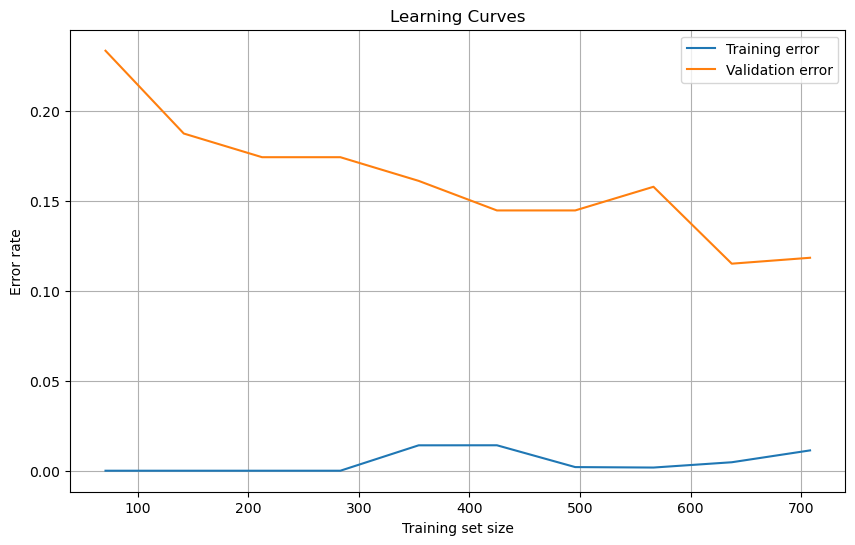

In [12]:
import matplotlib.pyplot as plt
def plot_learning_curves(X_train, y_train, X_val, y_val, alpha=0.005, iters=1000, lambda_=1.2):
    train_errors, val_errors = [], []
    m_range = np.linspace(0.1, 1.0, 10)  # Percentage of training data
    
    for m_pct in m_range:
        m = int(m_pct * len(X_train))
        initial_theta = np.random.uniform(-0.1, 0.1, (1, X.shape[1]))
        theta, _ = gradientDescent(X_train[:m], y_train[:m], initial_theta, alpha, iters, lambda_)
        
        # Training error
        y_train_pred = predict(X_train[:m], theta)
        train_errors.append(1 - accuracy_score(y_train[:m], y_train_pred))
        
        # Validation error
        y_val_pred = predict(X_val, theta)
        val_errors.append(1 - accuracy_score(y_val, y_val_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(m_range * len(X_train), train_errors, label='Training error')
    plt.plot(m_range * len(X_train), val_errors, label='Validation error')
    plt.xlabel('Training set size')
    plt.ylabel('Error rate')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
plot_learning_curves(X_train, y_train, X_val, y_val)

In [13]:
y_train_scores = sigmoid(X_train @ theta.T).flatten()
y_test_scores = sigmoid(X_test @ theta.T).flatten()
y_train_pred = (y_train_scores >= 0.5).astype(int)
y_test_pred = (y_test_scores >= 0.5).astype(int)


ROC Curves:
Training Set:


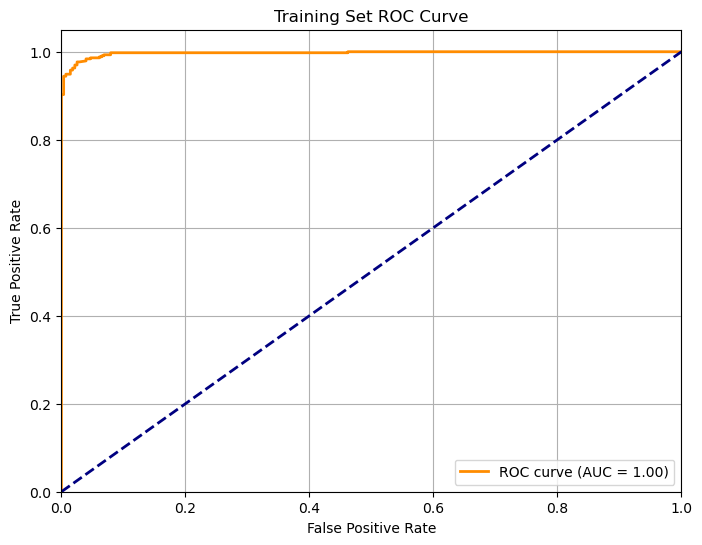

Test Set:


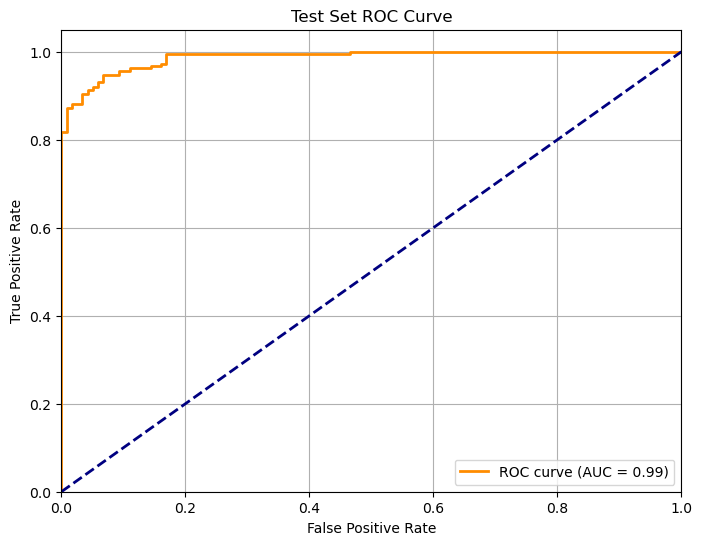


Precision-Recall Curves:
Training Set:


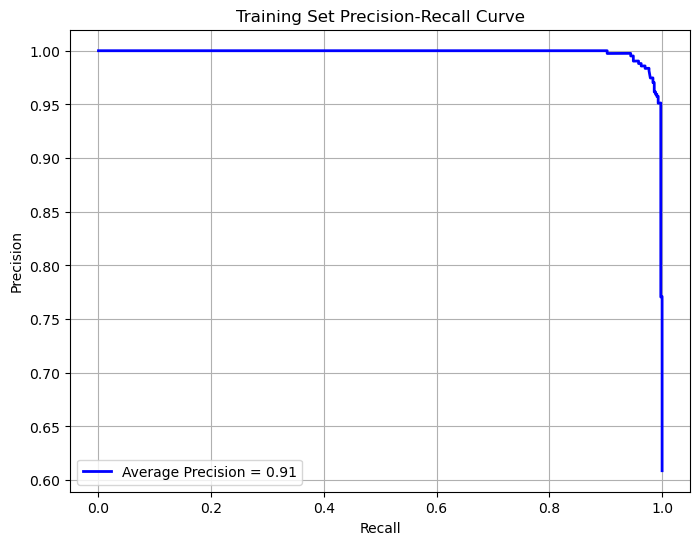

Test Set:


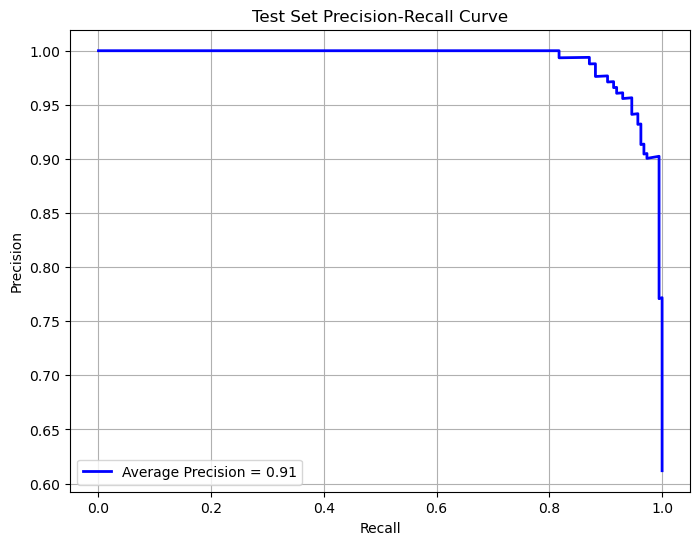


Confusion Matrices:
Training Set:


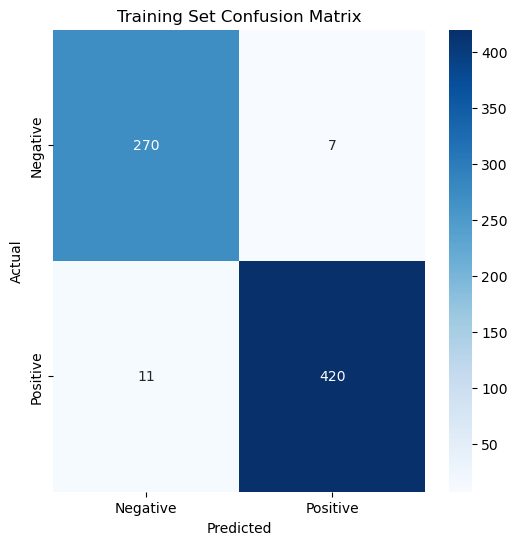

Test Set:


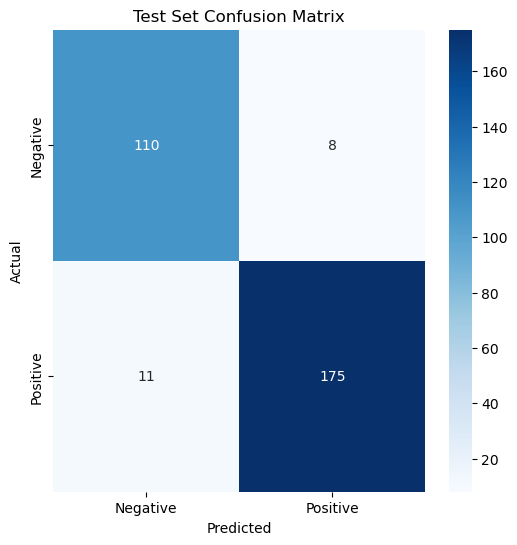


Training Progress:


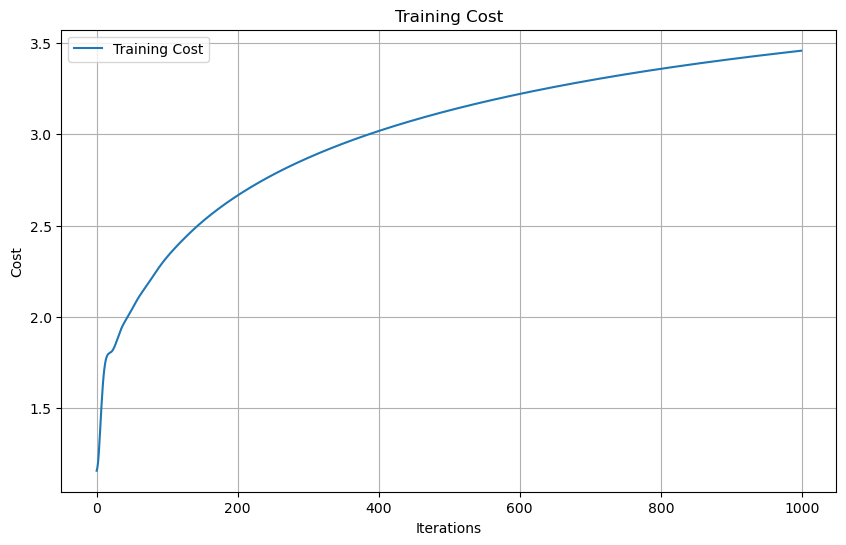


Probability Distributions:
Training Set:


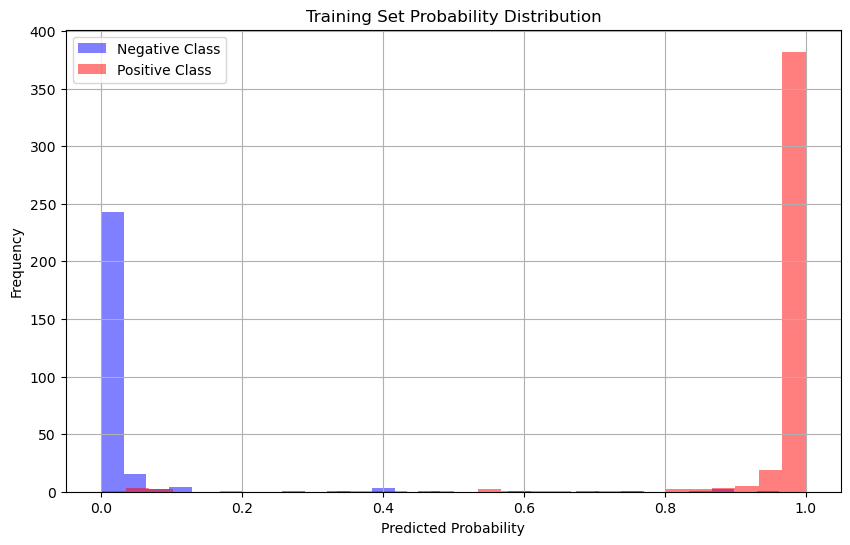

Test Set:


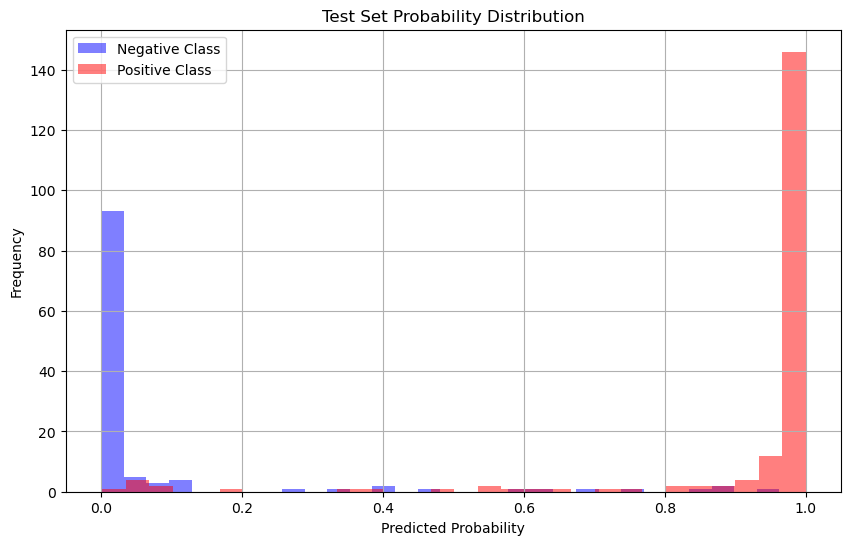


Threshold Analysis:


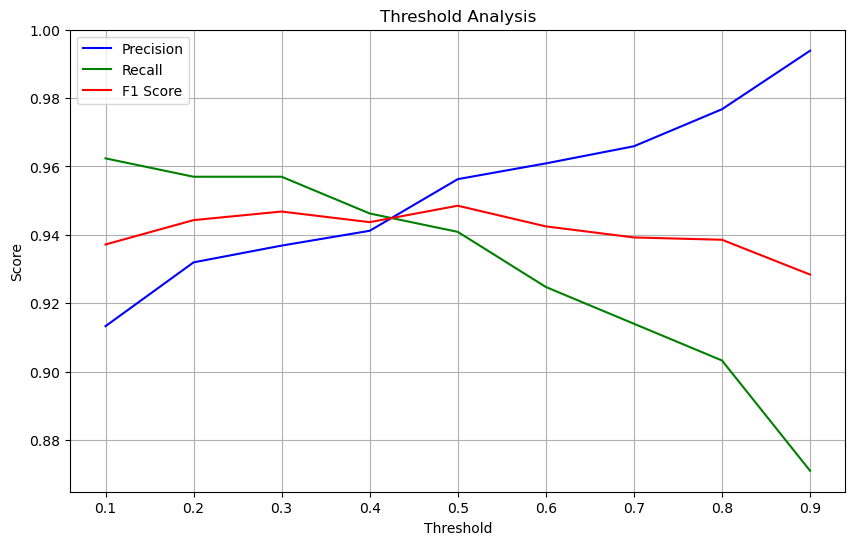


Cross-Validation Metrics Visualization:


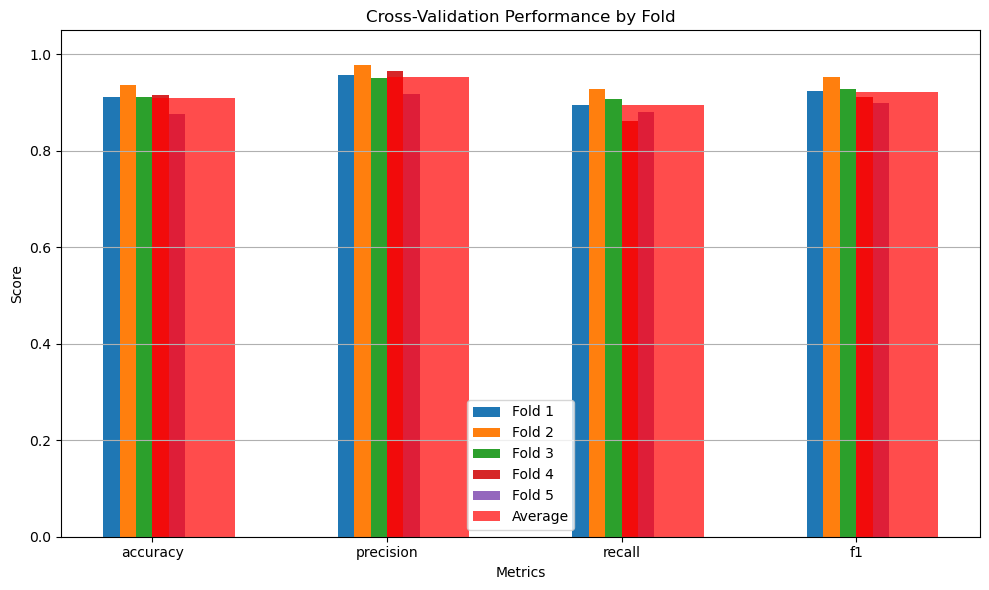

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. ROC Curve and AUC
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return roc_auc

# 2. Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision = np.mean(precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Average Precision = {average_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()
    
    return average_precision

# 3. Confusion Matrix Heatmap
def plot_confusion_matrix(y_true, y_pred, classes=None, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if classes is None:
        classes = ['Negative', 'Positive']
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# 4. Training Progress Curve
def plot_training_history(cost_history, val_cost_history=None, title='Training Progress'):
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history, label='Training Cost')
    if val_cost_history is not None:
        plt.plot(val_cost_history, label='Validation Cost')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Predicted Probability Distribution
def plot_probability_distribution(y_true, y_scores, title='Predicted Probability Distribution'):
    plt.figure(figsize=(10, 6))
    plt.hist(y_scores[y_true == 0], bins=30, alpha=0.5, label='Negative Class', color='blue')
    plt.hist(y_scores[y_true == 1], bins=30, alpha=0.5, label='Positive Class', color='red')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Threshold Analysis Curve
def plot_threshold_analysis(y_true, y_scores, thresholds=np.linspace(0.1, 0.9, 9)):
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, 'b-', label='Precision')
    plt.plot(thresholds, recalls, 'g-', label='Recall')
    plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Plot ROC curves
print("\nROC Curves:")
print("Training Set:")
train_auc = plot_roc_curve(y_train, y_train_scores, 'Training Set ROC Curve')
print("Test Set:")
test_auc = plot_roc_curve(y_test, y_test_scores, 'Test Set ROC Curve')

# 2. Plot Precision-Recall curves
print("\nPrecision-Recall Curves:")
print("Training Set:")
train_ap = plot_precision_recall_curve(y_train, y_train_scores, 'Training Set Precision-Recall Curve')
print("Test Set:")
test_ap = plot_precision_recall_curve(y_test, y_test_scores, 'Test Set Precision-Recall Curve')

# 3. Plot Confusion matrices
print("\nConfusion Matrices:")
print("Training Set:")
plot_confusion_matrix(y_train, y_train_pred, title='Training Set Confusion Matrix')
print("Test Set:")
plot_confusion_matrix(y_test, y_test_pred, title='Test Set Confusion Matrix')

# 4. Plot Training progress
if 'cost_history' in locals():
    print("\nTraining Progress:")
    if 'val_cost_history' in locals() and val_cost_history is not None:
        plot_training_history(cost_history, val_cost_history, 'Training and Validation Cost')
    else:
        plot_training_history(cost_history, title='Training Cost')

# 5. Plot Probability distributions
print("\nProbability Distributions:")
print("Training Set:")
plot_probability_distribution(y_train, y_train_scores, 'Training Set Probability Distribution')
print("Test Set:")
plot_probability_distribution(y_test, y_test_scores, 'Test Set Probability Distribution')

# 6. Threshold analysis
print("\nThreshold Analysis:")
plot_threshold_analysis(y_test, y_test_scores)

# Cross-validation results visualization
if 'cv_metrics' in locals():
    print("\nCross-Validation Metrics Visualization:")
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    avg_values = [cv_metrics[m] for m in metrics]
    fold_values = [[fold[m] for m in metrics] for fold in fold_metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    # Plot results for each fold
    for i, fold in enumerate(fold_values):
        plt.bar(x - width/2 + (i/len(fold_metrics))*width, fold, width/len(fold_metrics), 
                label=f'Fold {i+1}')
    
    # Plot average results
    plt.bar(x + width/2, avg_values, width, color='red', alpha=0.7, label='Average')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Cross-Validation Performance by Fold')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, axis='y')
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

## Step11: Record Time & Memory Cost

In [15]:
_report()


[STATS] runtime = 401.16 s
[STATS] memory  = 157.42 → 205.45 MB (Δ 48.03 MB)
